## Import all necessary modules

In [1]:
import math, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

## Prepare folder for data

In [2]:
# check if the folders for ExperimentalData exists; if not, create one
Path('./ExperimentalData/').mkdir(parents=True, exist_ok=True)
Path('./CompiledData/').mkdir(parents=True, exist_ok=True)
list_of_folders = ['AC','OSA','OSC','RF']
for i in list_of_folders:
    Path('./ExperimentalData/'+i+'/').mkdir(parents=True, exist_ok=True)


**Remember to place all data files in their corresponding folders before proceeding!**

## Read data in "ExperimentalData" folder

In [4]:
# assign path and make a list of all files in directory
# dirs will be the list of all folders (can use list_of_folders instead)....................................................................................................
path, dirs, files = next(os.walk("./ExperimentalData/"))
file_count = len(files)
Files=[]

# this is to keep track of the directories of all the data files ('dis' is not a typo)
for i in range(len(dirs)):
    path, dis, files = next(os.walk("./ExperimentalData/"+dirs[i]))
    Files.append(files)
    file_count = file_count + len(files)

# create empty list
dataframes_list = []
 
# append datasets to the list 
for k in range(len(dirs)):
    temp_df = []
    for i in range(len(Files[k])):
        # checks the AUTOCORRELATOR folder for txt files then append 
        if dirs[k] == 'AC' and Files[k][i].endswith('.txt'):
            data=[]
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as file:
                section, section2 = '',''
                for line in file:
                    if line.startswith("Delay") == True:
                        section = 'data'
                        if len(line.strip().split('\t')) == 1:
                            line = line.strip().split()
                            cname = line
                            section2 = 'data' 
                        else:
                            line = line.strip().split('\t')
                            cname = line  
                    elif section == 'data': 
                        if section2 == 'data':
                            line = line.strip().split()
                            if is_number(line[0]):
                                data.append(float(x) for x in line)
                        else:
                            line = line.strip().split('\t')
                            if is_number(line[0]):
                                data.append(float(x) for x in line)
                temper_df = pd.DataFrame(data,columns=cname)
                temper_df.index = range(len(temper_df))
                # add normalisation into data (min-max feature scaling method)
                temper_df['NormInt' + str(i)] = (temper_df[cname[1]] - temper_df[cname[1]].min()) \
                / (temper_df[cname[1]].max() - temper_df[cname[1]].min())
                temper_df['NormFit' + str(i)] = (temper_df[cname[2]] - temper_df[cname[2]].min()) \
                / (temper_df[cname[2]].max() - temper_df[cname[2]].min())
                row_index = (temper_df == 1).any(axis=1).idxmax()
                row = temper_df.loc[row_index]
                temper_df[cname[0]] = temper_df[cname[0]] - row[cname[0]]
                temper_df = temper_df.rename(columns={cname[0]:'Delay' + str(i) + '(ps)', cname[1]:'Intensity' + str(i), cname[2]:'Fit' + str(i)})
                if i == 0:
                    temp_df = temper_df
                else: 
                    temp_df = temp_df.join(temper_df)
        # checks the OSA folder for CSV files then append 
        elif dirs[k] == 'OSA' and Files[k][i].endswith('.CSV'):
            data = []
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                section = ''
                for line in f:
                    if line.strip() == '"[TRACE DATA]"':
                        section = 'data'
                    elif section == 'data':
                        data.append([float(x) for x in line.strip().split(',')])
                if i == 0:
                    temp_df = pd.DataFrame(data, columns=['Wavelength' + str(i) + ' (nm)', 'Intensity' + str(i) + ' (dBm)'])
                else:
                    temp_df = temp_df.join(pd.DataFrame(data, columns=['Wavelength' + str(i) + ' (nm)', 'Intensity' + str(i) + ' (dBm)']))
        # checks the OSCILLOSCOPE folder for files then append 
        elif dirs[k] == 'OSC':
            data = []
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                section = ''
                for line in f:
                    line = line.strip().split(',')
                    if is_number(line[0]) or section == 'data':
                        line = [x for x in line if x != '']
                        data.append([float(x) for x in line])
                    if line == '\n':
                        section = 'data'
                if i == 0:
                    temp_df = pd.DataFrame(data, columns=['Time' + str(i) + ' (s)','Voltage' + str(i) + ' (V)'])
                else:
                    temp_df = temp_df.join(pd.DataFrame(data, columns=['Time' + str(i) + ' (s)','Voltage' + str(i) + ' (V)']))
        # checks the RFSPECTRUM folder for csv files then append 
        elif dirs[k] == 'RF' and Files[k][i].endswith('.csv'):
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                data=[]
                section = ''
                for line in f:
                    if line == '\n':
                        section = 'data'
                    elif section == 'data':
                        line = line.strip().split(',')
                        while('' in line):
                            line.remove('')
                        if is_number(line[0]):
                            data.append(float(x) for x in line)
                if i == 0:
                    temp_df = pd.DataFrame(data,columns=['Frequency' + str(i) + ' (Hz)','Maximum' + str(i) + ' (dBm)', 'Minimum' + str(i) + ' (dBm)'])
                else:
                    temp_df = temp_df.join(pd.DataFrame(data,columns=['Frequency' + str(i) + ' (Hz)','Maximum' + str(i) + ' (dBm)', 'Minimum' + str(i) + ' (dBm)']))
    dataframes_list.append(temp_df)  


In [5]:
list_of_folders 

# set compile data save location
for x in list_of_folders:  
    compilefilelocation = './CompiledData/'
    if len(dataframes_list[dirs.index(x)]) > 0:
        dataframes_list[dirs.index(x)].to_csv(compilefilelocation + 'Compile' + x + '.csv',index=False)

## Read Compiled Data

In [14]:
# read compiled data
dataframes_list = pd.read_csv(compilefilelocation + 'Compile' + 'OSA' + '.csv')

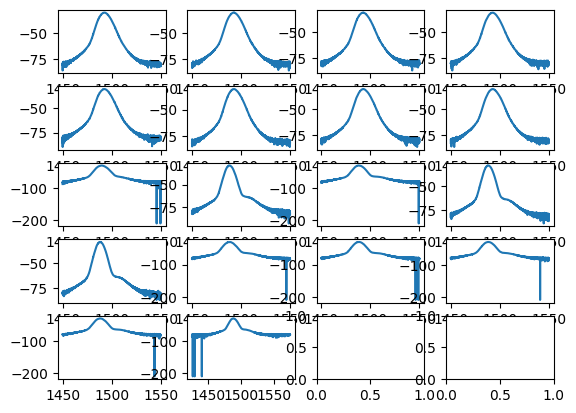

In [48]:
figure, axes = plt.subplots(math.ceil(len(dataframes_list.columns)/8),4)
n = 0

for x in range(0,math.ceil(len(dataframes_list.columns)/8)):
    for y in range(0,4):    
        if n < len(dataframes_list.columns):
            axes[x,y].plot(dataframes_list.iloc[:,n],dataframes_list.iloc[:,n+1])
            n = n + 2